# **Stars Classification**

This is a dataset consisting of several features of stars.

Some of them are:

- Absolute Temperature (in K)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
- Star Color (white,Red,Blue,Yellow,yellow-orange etc)
- Spectral Class (O,B,A,F,G,K,,M)
- Star Type **(Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants)**
- Lo = 3.828 x 10^26 Watts (Avg Luminosity of Sun)
- Ro = 6.9551 x 10^8 m (Avg Radius of Sun)

In [235]:
# import library
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import isnan, when, count, col, udf
from pyspark.sql.types import IntegerType, DoubleType, StringType
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

StatementMeta(sparkdadv3, 12, 143, Finished, Available)

## Data Loading

In [236]:
file_path = "abfss://fsdadv3@datalakedadv3.dfs.core.windows.net/data_stars/stars.csv"
star_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file_path)
star_df.show()

StatementMeta(sparkdadv3, 12, 144, Finished, Available)

+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|Temperature (K)|Luminosity (L/Lo)|Radius (R/Ro)|Absolute magnitude (Mv)|Star type|Star category|Star color|Spectral Class|
+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|           3068|           0.0024|         0.17|                  16.12|        0|  Brown Dwarf|       Red|             M|
|           3042|           5.0E-4|       0.1542|                   16.6|        0|  Brown Dwarf|       Red|             M|
|           2600|           3.0E-4|        0.102|                   18.7|        0|  Brown Dwarf|       Red|             M|
|           2800|           2.0E-4|         0.16|                  16.65|        0|  Brown Dwarf|       Red|             M|
|           1939|          1.38E-4|        0.103|                  20.06|        0|  Brown Dwarf|       Red|             M|
|       

In [237]:
for column_name in star_df.columns:
    new_column_name = column_name.strip().lower().replace(" ", "_")
    star_df = star_df.withColumnRenamed(column_name, new_column_name)

star_df.printSchema()

StatementMeta(sparkdadv3, 12, 145, Finished, Available)

root
 |-- temperature_(k): integer (nullable = true)
 |-- luminosity_(l/lo): double (nullable = true)
 |-- radius_(r/ro): double (nullable = true)
 |-- absolute_magnitude_(mv): double (nullable = true)
 |-- star_type: integer (nullable = true)
 |-- star_category: string (nullable = true)
 |-- star_color: string (nullable = true)
 |-- spectral_class: string (nullable = true)



In [238]:
star_df = star_df \
    .withColumn("temperature_(k)", col("temperature_(k)").cast(IntegerType())) \
    .withColumn("luminosity_(l/lo)", col("luminosity_(l/lo)").cast(DoubleType())) \
    .withColumn("radius_(r/ro)", col("radius_(r/ro)").cast(DoubleType())) \
    .withColumn("absolute_magnitude_(mv)", col("absolute_magnitude_(mv)").cast(DoubleType())) \
    .withColumn("star_type", col("star_type").cast(IntegerType()))

star_df.printSchema()

StatementMeta(sparkdadv3, 12, 146, Finished, Available)

root
 |-- temperature_(k): integer (nullable = true)
 |-- luminosity_(l/lo): double (nullable = true)
 |-- radius_(r/ro): double (nullable = true)
 |-- absolute_magnitude_(mv): double (nullable = true)
 |-- star_type: integer (nullable = true)
 |-- star_category: string (nullable = true)
 |-- star_color: string (nullable = true)
 |-- spectral_class: string (nullable = true)



In [239]:
print("Número de filas:", star_df.count())
print("Número de columnas:", len(star_df.columns))

StatementMeta(sparkdadv3, 12, 147, Finished, Available)

Número de filas: 240
Número de columnas: 8


## EDA

In [240]:
numeric_features = [t[0] for t in star_df.dtypes if (t[1] == 'int' or t[1] == 'double') and t[0] != 'star_type']
star_df.select(numeric_features).summary().show()

StatementMeta(sparkdadv3, 12, 148, Finished, Available)

+-------+----------------+------------------+------------------+-----------------------+
|summary| temperature_(k)| luminosity_(l/lo)|     radius_(r/ro)|absolute_magnitude_(mv)|
+-------+----------------+------------------+------------------+-----------------------+
|  count|             240|               240|               240|                    240|
|   mean|      10497.4625|107188.36163460833|237.15778137500004|      4.382395833333335|
| stddev|9552.42503716402| 179432.2449402145| 517.1557634028477|      10.53251235061617|
|    min|            1939|            8.0E-5|            0.0084|                 -11.92|
|    25%|            3342|           8.49E-4|             0.102|                  -6.24|
|    50%|            5752|             0.056|              0.73|                  6.506|
|    75%|           14982|          198000.0|              42.0|                  13.67|
|    max|           40000|          849420.0|            1948.5|                  20.06|
+-------+------------

In [241]:
# number of categories
def describe_categories():
    star_df.groupBy('spectral_class').count().show()
    star_df.groupBy('star_type').count().show()
    star_df.groupBy('star_category').count().show()
    star_df.groupBy('star_color').count().show()

describe_categories()

StatementMeta(sparkdadv3, 12, 149, Finished, Available)

+--------------+-----+
|spectral_class|count|
+--------------+-----+
|             K|    6|
|             F|   17|
|             B|   46|
|             M|  111|
|             O|   40|
|             A|   19|
|             G|    1|
+--------------+-----+

+---------+-----+
|star_type|count|
+---------+-----+
|        1|   40|
|        3|   40|
|        5|   40|
|        4|   40|
|        2|   40|
|        0|   40|
+---------+-----+

+-------------+-----+
|star_category|count|
+-------------+-----+
|   Supergiant|   40|
|  Brown Dwarf|   40|
|  White Dwarf|   40|
|   Hypergiant|   40|
|    Red Dwarf|   40|
|Main Sequence|   40|
+-------------+-----+

+------------------+-----+
|        star_color|count|
+------------------+-----+
|         yellowish|    2|
|            Orange|    2|
|Pale yellow orange|    1|
|   Yellowish White|    3|
|        Blue-White|    1|
|             white|    3|
|        Orange-Red|    1|
|      yellow-white|    8|
|        Blue-white|   26|
|             Blue |

In [242]:
def preprocess_categorical(value):
    if value is not None:
        return value.strip().lower().replace(" ", "-")
    else:
        return None

preprocess_categorical_udf = udf(preprocess_categorical, StringType())

for column in ["star_category", "star_color", "spectral_class"]:
    star_df = star_df.withColumn(column, preprocess_categorical_udf(column))

describe_categories()

StatementMeta(sparkdadv3, 12, 150, Finished, Available)

+--------------+-----+
|spectral_class|count|
+--------------+-----+
|             g|    1|
|             m|  111|
|             f|   17|
|             k|    6|
|             o|   40|
|             b|   46|
|             a|   19|
+--------------+-----+

+---------+-----+
|star_type|count|
+---------+-----+
|        1|   40|
|        3|   40|
|        5|   40|
|        4|   40|
|        2|   40|
|        0|   40|
+---------+-----+

+-------------+-----+
|star_category|count|
+-------------+-----+
|main-sequence|   40|
|  brown-dwarf|   40|
|   hypergiant|   40|
|  white-dwarf|   40|
|    red-dwarf|   40|
|   supergiant|   40|
+-------------+-----+

+------------------+-----+
|        star_color|count|
+------------------+-----+
|            orange|    2|
|        blue-white|   41|
|         yellowish|    3|
|           whitish|    2|
|             white|   10|
|               red|  112|
|      yellow-white|    8|
|        orange-red|    1|
|pale-yellow-orange|    1|
|   yellowish-white|

In [243]:
numeric_features = [t[0] for t in star_df.dtypes if t[1] in ['int', 'double'] and t[0] != 'star_type']
for feature in numeric_features:
    for other_feature in numeric_features:
        if feature != other_feature:
            print(f"Correlación entre {feature} y {other_feature}:",
                  star_df.stat.corr(feature, other_feature))


StatementMeta(sparkdadv3, 12, 151, Finished, Available)

Correlación entre temperature_(k) y luminosity_(l/lo): 0.393404075509761
Correlación entre temperature_(k) y radius_(r/ro): 0.06421597240596888
Correlación entre temperature_(k) y absolute_magnitude_(mv): -0.42026054236947286
Correlación entre luminosity_(l/lo) y temperature_(k): 0.393404075509761
Correlación entre luminosity_(l/lo) y radius_(r/ro): 0.5265157243480015
Correlación entre luminosity_(l/lo) y absolute_magnitude_(mv): -0.6926192333999417
Correlación entre radius_(r/ro) y temperature_(k): 0.06421597240596887
Correlación entre radius_(r/ro) y luminosity_(l/lo): 0.5265157243480015
Correlación entre radius_(r/ro) y absolute_magnitude_(mv): -0.6087282328465601
Correlación entre absolute_magnitude_(mv) y temperature_(k): -0.4202605423694728
Correlación entre absolute_magnitude_(mv) y luminosity_(l/lo): -0.6926192333999417
Correlación entre absolute_magnitude_(mv) y radius_(r/ro): -0.6087282328465601


In [244]:
# Conteo de valores únicos para cada columna
for column in star_df.columns:
    unique_count = star_df.select(column).distinct().count()
    print(f"{column} tiene {unique_count} valores únicos")

# Conteo de valores nulos para cada columna
null_counts = star_df.select([count(when(col(c).isNull(), c)).alias(c) for c in star_df.columns])
null_counts.show()

StatementMeta(sparkdadv3, 12, 152, Finished, Available)

temperature_(k) tiene 228 valores únicos
luminosity_(l/lo) tiene 208 valores únicos
radius_(r/ro) tiene 216 valores únicos
absolute_magnitude_(mv) tiene 228 valores únicos
star_type tiene 6 valores únicos
star_category tiene 6 valores únicos
star_color tiene 12 valores únicos
spectral_class tiene 7 valores únicos
+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|temperature_(k)|luminosity_(l/lo)|radius_(r/ro)|absolute_magnitude_(mv)|star_type|star_category|star_color|spectral_class|
+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|              0|                0|            0|                      0|        0|            0|         0|             0|
+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+



StatementMeta(sparkdadv3, 12, 153, Finished, Available)

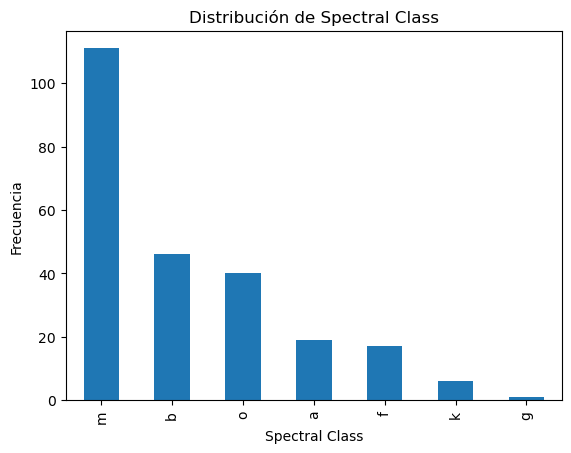

In [245]:
# Asegúrate de que tu conjunto de datos no sea demasiado grande para evitar problemas de memoria
pandas_df = star_df.toPandas()

pandas_df['spectral_class'].value_counts().plot(kind='bar')
plt.title('Distribución de Spectral Class')
plt.xlabel('Spectral Class')
plt.ylabel('Frecuencia')
plt.show()

StatementMeta(sparkdadv3, 12, 154, Finished, Available)

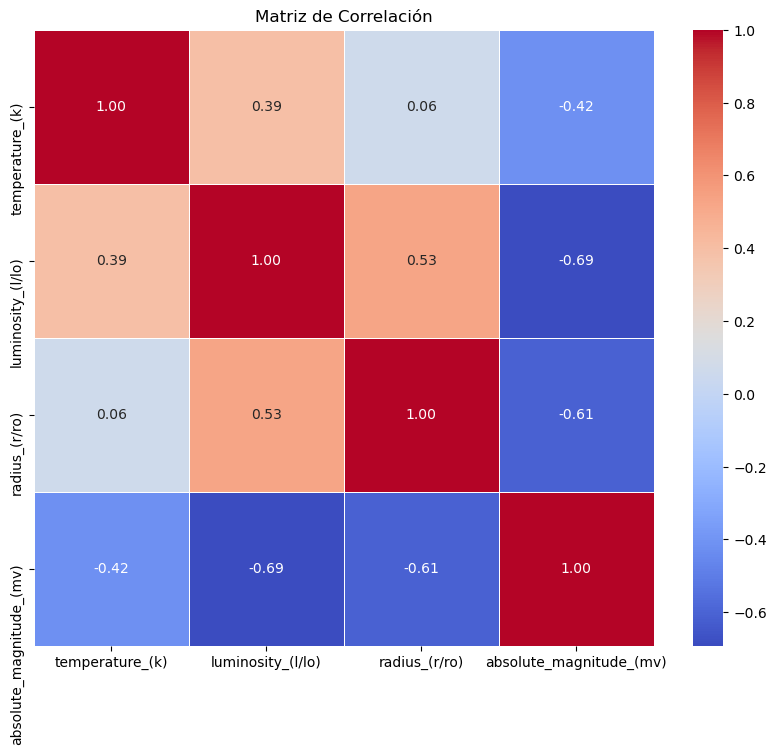

In [246]:
numeric_features_df = pandas_df[numeric_features]
correlation_matrix = numeric_features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

In [247]:
# Definir StringIndexer para cada columna categórica
indexer_spectral_class = StringIndexer(inputCol="spectral_class", outputCol="spectral_class_index_tmp")
indexer_star_color = StringIndexer(inputCol="star_color", outputCol="star_color_index_tmp")
indexer_star_category = StringIndexer(inputCol="star_category", outputCol="star_category_index_tmp")

# Construir y ejecutar el pipeline
pipeline = Pipeline(stages=[indexer_spectral_class, indexer_star_color, indexer_star_category])
star_df_transformed = pipeline.fit(star_df).transform(star_df)

# Convertir los índices flotantes a enteros
star_df_transformed = star_df_transformed \
    .withColumn("spectral_class", col("spectral_class_index_tmp").cast(IntegerType())) \
    .withColumn("star_color", col("star_color_index_tmp").cast(IntegerType())) \
    .withColumn("star_category", col("star_category_index_tmp").cast(IntegerType()))

# Eliminar columnas temporales
star_df_transformed = star_df_transformed.drop("spectral_class_index_tmp", "star_color_index_tmp", "star_category_index_tmp")

# Mostrar los resultados
star_df_transformed.show()

StatementMeta(sparkdadv3, 12, 155, Finished, Available)

+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|temperature_(k)|luminosity_(l/lo)|radius_(r/ro)|absolute_magnitude_(mv)|star_type|star_category|star_color|spectral_class|
+---------------+-----------------+-------------+-----------------------+---------+-------------+----------+--------------+
|           3068|           0.0024|         0.17|                  16.12|        0|            0|         0|             0|
|           3042|           5.0E-4|       0.1542|                   16.6|        0|            0|         0|             0|
|           2600|           3.0E-4|        0.102|                   18.7|        0|            0|         0|             0|
|           2800|           2.0E-4|         0.16|                  16.65|        0|            0|         0|             0|
|           1939|          1.38E-4|        0.103|                  20.06|        0|            0|         0|             0|
|       

In [248]:
star_df.head()

StatementMeta(sparkdadv3, 12, 156, Finished, Available)

Row(temperature_(k)=3068, luminosity_(l/lo)=0.0024, radius_(r/ro)=0.17, absolute_magnitude_(mv)=16.12, star_type=0, star_category='brown-dwarf', star_color='red', spectral_class='m')

In [249]:
star_df_transformed.head()

StatementMeta(sparkdadv3, 12, 157, Finished, Available)

Row(temperature_(k)=3068, luminosity_(l/lo)=0.0024, radius_(r/ro)=0.17, absolute_magnitude_(mv)=16.12, star_type=0, star_category=0, star_color=0, spectral_class=0)

In [250]:
# # Registrar el DataFrame como una tabla temporal
star_df.createOrReplaceTempView("stars")

# # Guardar el DataFrame en formato CSV en ADLS
star_df.write.mode("overwrite").option("header", "true").csv("abfss://fsdadv3@datalakedadv3.dfs.core.windows.net/data_stars/stars_csv")

# Guardar el DataFrame en formato Parquet en ADLS
star_df.write.mode("overwrite").parquet("abfss://fsdadv3@datalakedadv3.dfs.core.windows.net/data_stars/stars_parquet")

StatementMeta(sparkdadv3, 12, 158, Finished, Available)

In [251]:
# # Registrar el DataFrame como una tabla temporal
star_df_transformed.createOrReplaceTempView("stars_transformed")

# # Guardar el DataFrame en formato CSV en ADLS
star_df_transformed.write.mode("overwrite").option("header", "true").csv("abfss://fsdadv3@datalakedadv3.dfs.core.windows.net/data_stars/stars_transformed_csv")

# Guardar el DataFrame en formato Parquet en ADLS
star_df_transformed.write.mode("overwrite").parquet("abfss://fsdadv3@datalakedadv3.dfs.core.windows.net/data_stars/stars_transformed_parquet")

StatementMeta(sparkdadv3, 12, 159, Finished, Available)

In [257]:
%%sql
SELECT * FROM stars_transformed LIMIT 10

StatementMeta(sparkdadv3, 12, 165, Finished, Available)

<Spark SQL result set with 10 rows and 8 fields>

In [258]:
%%sql
SELECT * FROM stars_transformed WHERE star_color = 0

StatementMeta(sparkdadv3, 12, 166, Finished, Available)

<Spark SQL result set with 112 rows and 8 fields>

In [261]:
filtered_df = star_df_transformed.filter(star_df_transformed.star_color == 0)

display(filtered_df)

StatementMeta(sparkdadv3, 12, 169, Finished, Available)

SynapseWidget(Synapse.DataFrame, bc550a73-d5b2-44b4-9eb0-23454d354d79)